Get recommendation from song input based on model.pickle. 

In [1]:
from ScrapeLast10weeksBillboard import time_to_scrape
from CheckHotNot import load_billboard_csv
from CheckHotNot import check_if_hot
from CheckHotNot import get_random_hot_song
from songrecommender import show_if_hot
from songrecommender import get_song_df, showID_in_player
from scalingclustering import load_pkl, predict_kmeans
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import config
import pandas as pd
from IPython.display import IFrame
from harmonicneighbours import translate_pc_cam, translate_cam_pc, harmonic_sibblings

## 1. Check if we should scrape the Billboard.

Is it time to scrape the billboard100 songs? 

In [2]:
time_to_scrape()

Our last data is from 2022-04-23


Would you like to get the current Top 100 now?(Y/N) n


## 2. Get song title and check if it is hot right now:

Get song input from user and check if it is in the Billboard Top100:

In [3]:
result, user_input =  check_if_hot()

Give me your song title! allah


No song similar to allah is hot right now.


If the song is hot another hot song is randomly selected. Alternatively we search for the title on spotify.

In [4]:
song_df = show_if_hot(result, user_input['title'])
song_df

    

not hot process


,TrackName,TrackID,SampleURL,ReleaseYear,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,mode,duration_ms,Popularity
0,Allahu (feat. Yousuf & Coskun),6Pp6RnnOWfIb6BZ6OZi2ph,https://open.spotify.com/track/6Pp6RnnOWfIb6BZ...,2012-08-10,0.323,0.254,-7.824,0.0267,0.851,0.000002,0.105,0.267,101.089,3,0,299293,54


## 3. import pickle model

We load the model to apply it to the song we found on spotify.

In [5]:
scaler = load_pkl(filename='model/scalerKmeans.pickle')
kmeans = load_pkl(filename = 'model/modelKmeans.pickle')
X = load_pkl(filename=  'model/X.pickle')
X_scaled_df = load_pkl(filename ='model/X_scaled_df')
sp_library = load_pkl(filename ='model/sp_library.pickle')

## 4. scale song

We scale the song and predict the cluster: 

In [6]:
song_df['Year'] = pd.to_datetime(song_df['ReleaseYear'], format='%Y-%m-%d')
song_df['Year'] = pd.DatetimeIndex(song_df['Year']).year

In [7]:
song_df_scaled = scaler.transform(song_df[X_scaled_df.columns])

C:\Users\Lenovo\anaconda3\envs\DA_Env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


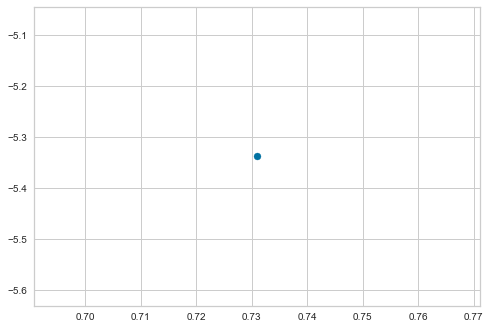

In [8]:
song_label, song_cluster = predict_kmeans(song_df_scaled, X, kmeans)

we add the cluster as a label

In [9]:
song_df['label'] = song_label

## 5. Get song suggestion from same cluster and show spotify player

### Key/mode: Get harmonic neighbours:

In [10]:
song_key = song_df['key'].iloc[0]
song_mode = song_df['mode'].iloc[0]
song_key, song_mode

(3, 0)

Translate key and mode to camelot:

In [11]:
key_cam = translate_pc_cam(song_key, song_mode)
#key_cam = key_cam[0]
key_cam

'05B'

Get neighbours:

In [12]:
neighbours = harmonic_sibblings(key_cam)
neighbours

['06B', '04B', '11B', '12A']

Translate back to key/mode pairs:

In [13]:
pos_key_modes = [translate_cam_pc(neighbour) for neighbour in neighbours]
pos_key_modes

['A#', 'Bb'] major
['G#', 'Ab'] major
A major
['C#', 'Db'] minor


[([10], [0]), ([8], [0]), ([9], [0]), ([1], [1])]

Filter cluster for possible key/mode combination:

In [14]:
song_suggest_cluster = sp_library[sp_library['label']==song_df['label'][0]]

In [29]:
filtered_df = pd.DataFrame(columns=song_suggest_cluster.columns) 
for i in pos_key_modes:
    filtered_df = pd.concat([filtered_df, song_suggest_cluster.loc[(song_suggest_cluster['key']==i[0][0]) & (song_suggest_cluster['mode']==i[1][0]), :]])
song_suggest_cluster = filtered_df    

### Filter for tempo:

In [32]:
#song_suggest_cluster = song_suggest_cluster[song_suggest_cluster['tempo']>(song_df['tempo']*0.92) and song_suggest_cluster['tempo']<(song_df['tempo']*1.08)]

In [16]:
song_suggest =  song_suggest_cluster.sample()
song_suggest_TrackID = song_suggest['TrackID'].iloc[0]

In [17]:
song_suggest_TrackID

'4soinNVuhmLyhdPhz8vnbq'

## Comparing songs

In [18]:
df_compair = pd.concat([song_df, song_suggest], axis=0)
df_compair.iloc[:,0:9]

,TrackName,TrackID,SampleURL,ReleaseYear,danceability,energy,loudness,speechiness,acousticness
0,Allahu (feat. Yousuf & Coskun),6Pp6RnnOWfIb6BZ6OZi2ph,https://open.spotify.com/track/6Pp6RnnOWfIb6BZ...,2012-08-10,0.323,0.254,-7.824,0.0267,0.851
47,blitzlys,4soinNVuhmLyhdPhz8vnbq,https://p.scdn.co/mp3-preview/7ec87fd8b1916cdc...,2022-01-14,0.787,0.341,-9.337,0.046,0.443


In [19]:
df_compair.iloc[:,10:19]

,liveness,valence,tempo,key,mode,duration_ms,Popularity,Year,label
0,0.105,0.267,101.089,3,0,299293,54,2012,4
47,0.101,0.745,84.106,1,1,150555,48.0,2022,4


In [20]:
player_user_choice = showID_in_player(song_df.loc[0, 'TrackID'])
print(f'This is your recommendation:')
player_user_choice

This is your recommendation:


In [21]:
player_recommendation = showID_in_player(song_suggest_TrackID)
print(f'This is your recommendation:')
player_recommendation


This is your recommendation:
